In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Helper to load a file like rho_out.txt
def load_field(filename):
    data = []
    zs = []
    with open(filename) as f:
        lines = f.readlines()
    i = 0
    while i < len(lines):
        # skip empty lines
        if not lines[i].strip():
            i += 1
            continue
        # first line is z
        z = float(lines[i].strip())
        zs.append(z)
        i += 1
        # next N lines until blank
        block = []
        while i < len(lines) and lines[i].strip():
            row = list(map(float, lines[i].split()))
            block.append(row)
            i += 1
        data.append(block)
    return np.array(zs), np.array(data)  # zs: (K,), data: (K, N, M)

In [21]:
# Body radius function
def r_b(z):
    # return np.tan(np.pi/12) * np.sqrt(2*z - 1)
    return np.tan(np.pi/12) * z

In [75]:
# Load fields
zs, rho = load_field('rho_out.txt')
_, p = load_field('p_out.txt')
_, u = load_field('u_out.txt')
_, v = load_field('v_out.txt')
_, w = load_field('w_out.txt')
# Load r_s
rs = []
zs_rs = []
with open('r_s_out.txt') as f:
    for line in f:
        parts = list(map(float, line.split()))
        zs_rs.append(parts[0])
        rs.append(parts[1:])
rs = np.array(rs)  # (K, M)
zs_rs = np.array(zs_rs)
z0 = 1

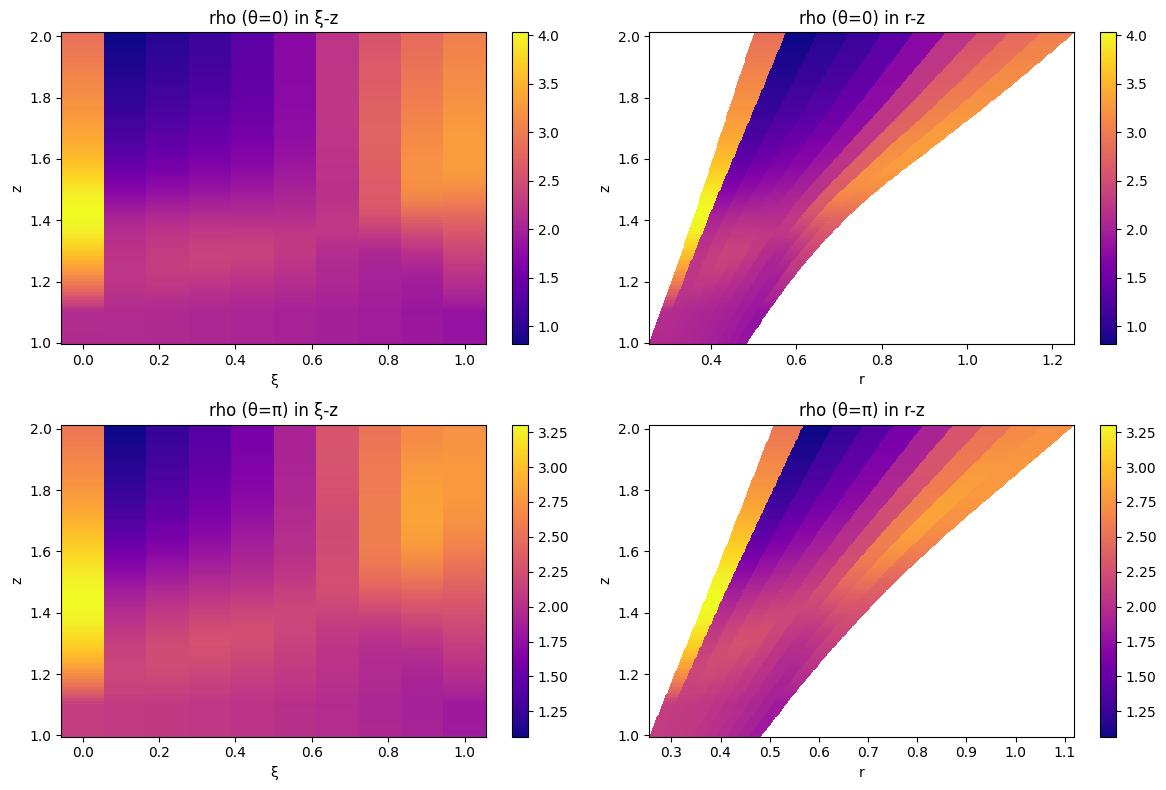

In [76]:
# Choose theta indices: 0 and M-1
K, N, M = rho.shape
xi = np.linspace(0, 1, N)

# Extract slices for theta=0
rho_theta0 = rho[:, :, 0]     # shape (K,N)
rho_thetap = rho[:, :, -1]

# Now plot for rho at theta=0
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# Normalized (xi, z)
im0 = axs[0,0].pcolormesh(xi, zs, rho_theta0, shading='auto', cmap='plasma')
axs[0,0].set_title('rho (θ=0) in ξ-z')
axs[0,0].set_ylabel('z')
axs[0,0].set_xlabel('ξ')
fig.colorbar(im0, ax=axs[0,0])

# Physical r: need r = r_b(z) + ξ*(r_s(z) - r_b(z))
# For theta=0, r_s = rs[:,0]
r_phys = np.zeros_like(rho_theta0)
for k in range(K):
    r_phys[k,:] = r_b(zs[k]) + xi*(rs[k,0] - r_b(zs[k]))

im1 = axs[0,1].pcolormesh(r_phys, zs, rho_theta0, shading='auto', cmap='plasma')
axs[0,1].set_title('rho (θ=0) in r-z')
axs[0,1].set_xlabel('r')
axs[0,1].set_ylabel('z')
fig.colorbar(im1, ax=axs[0,1])

# Repeat for theta=π
im2 = axs[1,0].pcolormesh(xi, zs, rho_thetap, shading='auto', cmap='plasma')
axs[1,0].set_title('rho (θ=π) in ξ-z')
axs[1,0].set_xlabel('ξ')
axs[1,0].set_ylabel('z')
fig.colorbar(im2, ax=axs[1,0])

r_phys_p = np.zeros_like(rho_thetap)
for k in range(K):
    r_phys_p[k,:] = r_b(zs[k]) + xi*(rs[k,-1] - r_b(zs[k]))

im3 = axs[1,1].pcolormesh(r_phys_p, zs, rho_thetap, shading='auto', cmap='plasma')
axs[1,1].set_title('rho (θ=π) in r-z')
axs[1,1].set_xlabel('r')
axs[1,1].set_ylabel('z')
fig.colorbar(im3, ax=axs[1,1])

plt.tight_layout()
plt.show()

In [66]:
# φ и p(φ), ρ(φ), V_R(φ), V_θ(φ)
data_p   = np.loadtxt('p_init.txt')            # shape (L,2): [φ, p]
data_rho = np.loadtxt('rho_init.txt')          # shape (L,2): [φ, ρ]
data_vr_vtheta = np.loadtxt('VR_Vtheta_init.txt')

phi_cone, p_cone = data_p[::-1,0], data_p[::-1,1]
_, rho_cone = data_rho[::-1,0], data_rho[::-1,1]
_, VR_cone, Vtheta_cone = data_vr_vtheta[::-1,0], data_vr_vtheta[::-1,1], data_vr_vtheta[::-1,2]

In [67]:
def distribution_plot(f_name):
    f_dict = {
        'p': p,
        'rho': rho,
        'u': u,
        'v': v,
        'w': w
    }
    f_cone_dict = {
        'p': p_cone,
        'rho': rho_cone,
        'u': np.sin(phi_cone)*VR_cone + np.cos(phi_cone)*Vtheta_cone,
        'v': np.zeros_like(p_cone),
        'w': np.cos(phi_cone)*VR_cone - np.sin(phi_cone)*Vtheta_cone
    }
    fig, ax = plt.subplots(figsize=(15,9))
    vmin = min(np.min(f_dict[f_name]), np.min(f_cone_dict[f_name]))
    vmax = max(np.max(f_dict[f_name]), np.max(f_cone_dict[f_name]))
    pcm = ax.pcolormesh(np.tile(zs, (N, 1)).T, r_phys, f_dict[f_name][:,:,0], shading='auto', cmap='plasma', vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(np.tile(zs, (N, 1)).T, -r_phys, f_dict[f_name][:,:,-1], shading='auto', cmap='plasma', vmin=vmin, vmax=vmax)
    
    z_cone = np.linspace(0, z0, 200)
    pcm = ax.pcolormesh(np.tile(z_cone, (phi_cone.shape[0], 1)), np.outer(np.tan(phi_cone), z_cone), np.tile(f_cone_dict[f_name], (z_cone.shape[0], 1)).T, shading='auto', cmap='plasma', vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(np.tile(z_cone, (phi_cone.shape[0], 1)), -np.outer(np.tan(phi_cone), z_cone), np.tile(f_cone_dict[f_name], (z_cone.shape[0], 1)).T, shading='auto', cmap='plasma', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, label='ρ')
    ax.set_xlabel('z')
    ax.set_ylabel('r')
    plot_label_dict = {
        'p': 'давления p(z,r)',
        'rho': 'плотности ρ(z,r)',
        'u': 'скорости u(z,r)',
        'v': 'скорости v(z,r)',
        'w': 'скорости w(z,r)'
    }
    ax.set_title('Полное распределение ' + plot_label_dict[f_name])
    plt.show()

C:\Users\bator\AppData\Local\Temp\ipykernel_19052\1528305571.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(np.tile(z_cone, (phi_cone.shape[0], 1)), np.outer(np.tan(phi_cone), z_cone), np.tile(f_cone_dict[f_name], (z_cone.shape[0], 1)).T, shading='auto', cmap='plasma', vmin=vmin, vmax=vmax)
C:\Users\bator\AppData\Local\Temp\ipykernel_19052\1528305571.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(np.tile(z_cone, (phi_cone.shape[0], 1)), -np.outer(np.tan(phi_cone), z_cone), np.tile(f_cone_dict[f_name], (z_cone.shape[0], 1)).T, shad

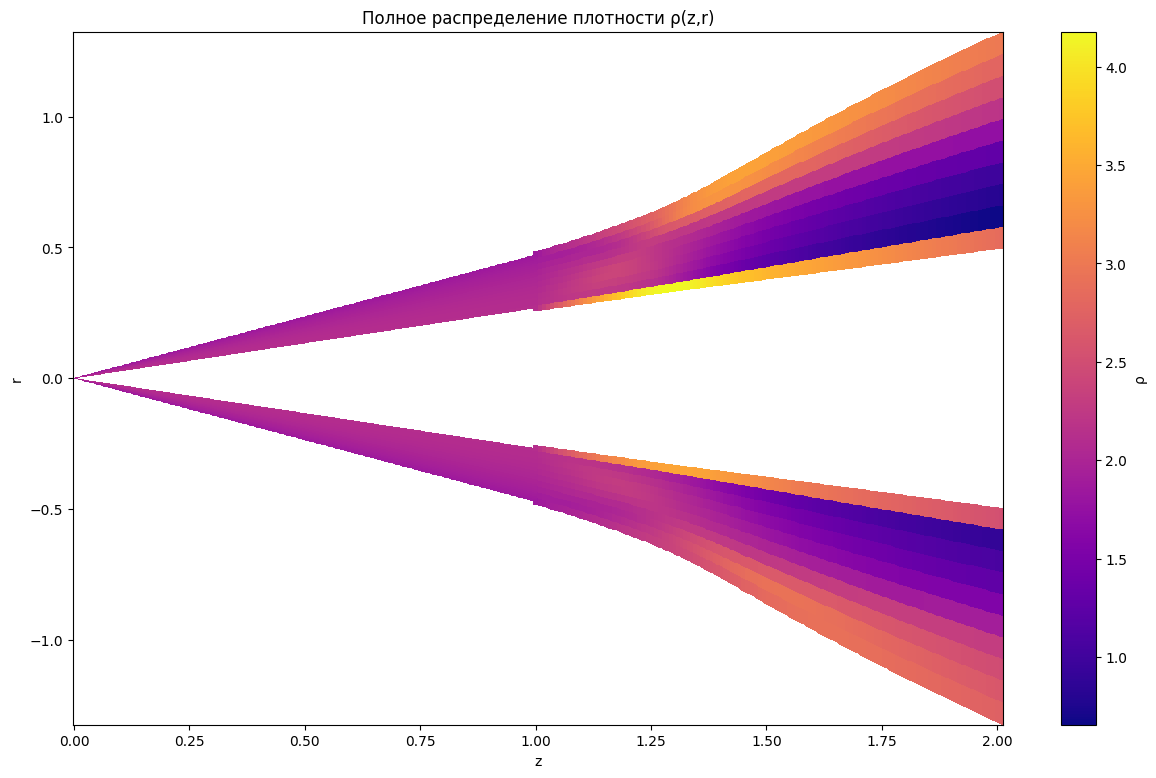

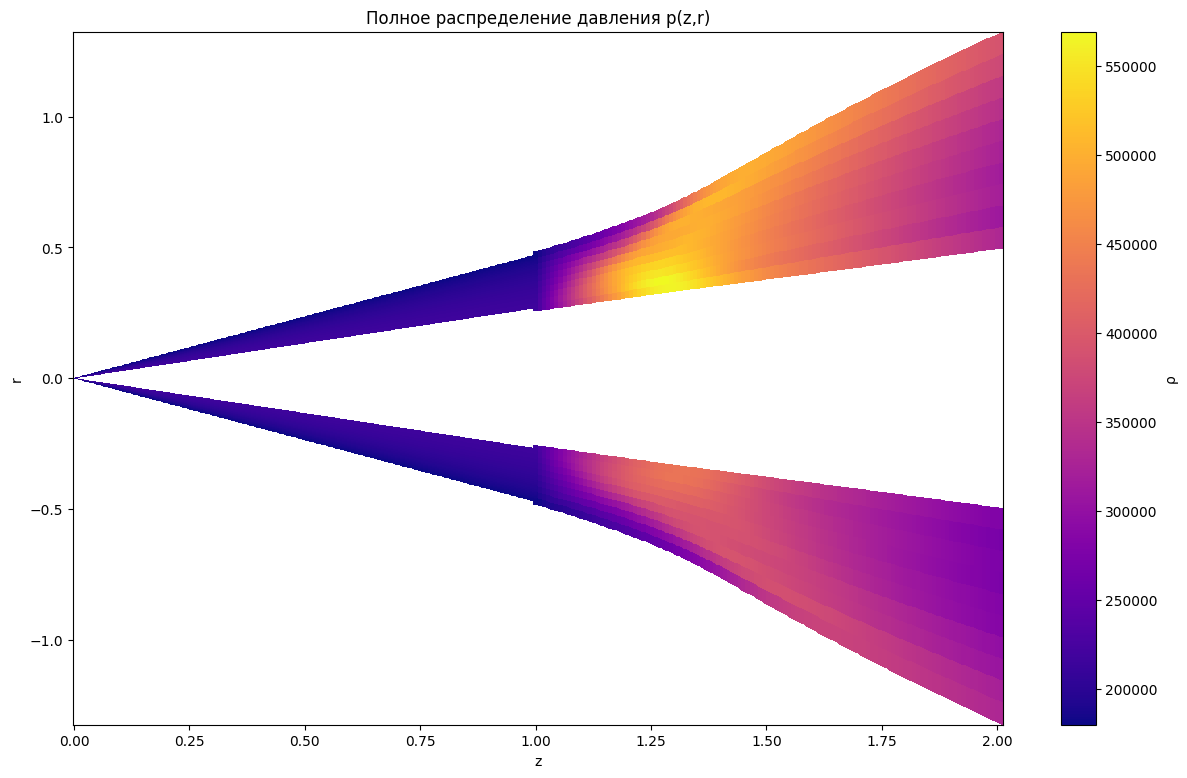

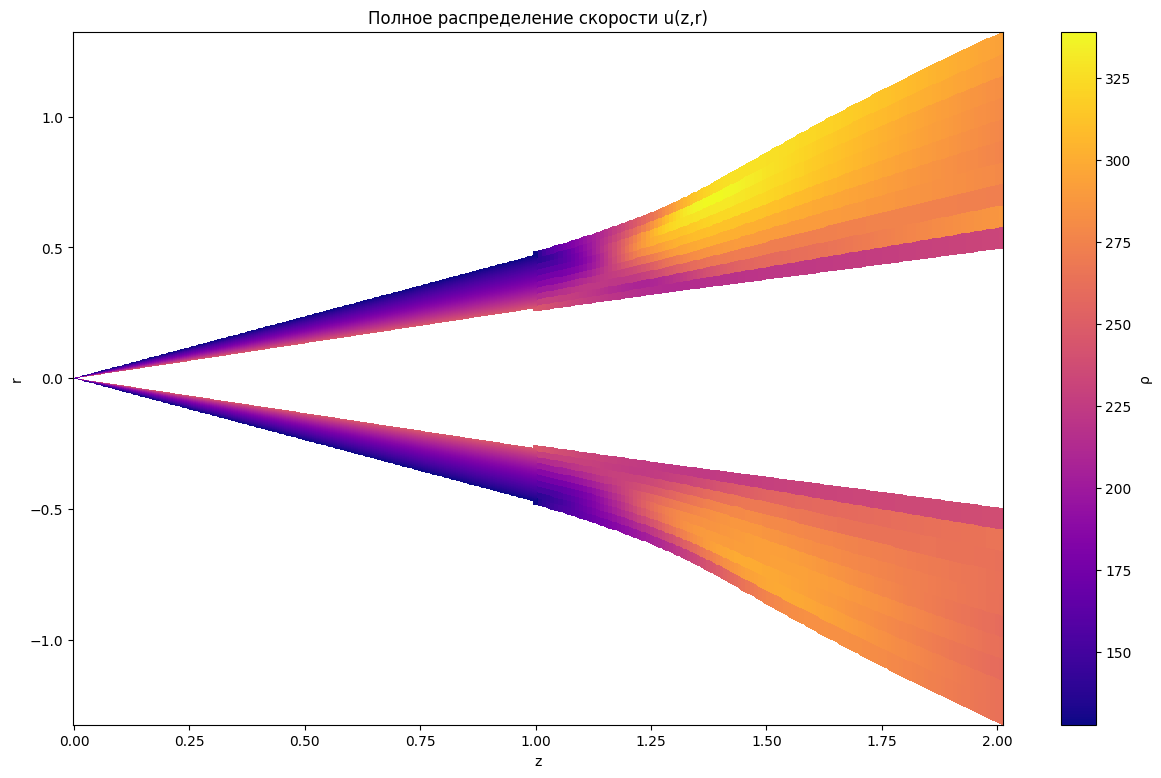

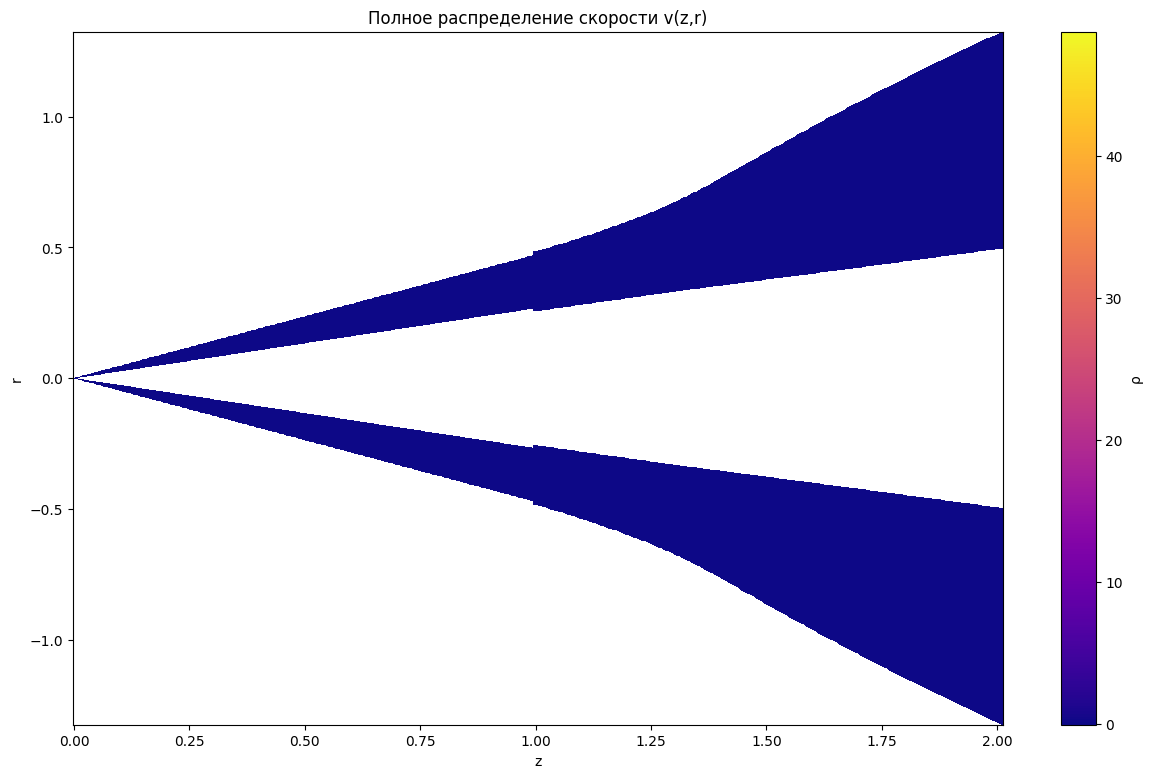

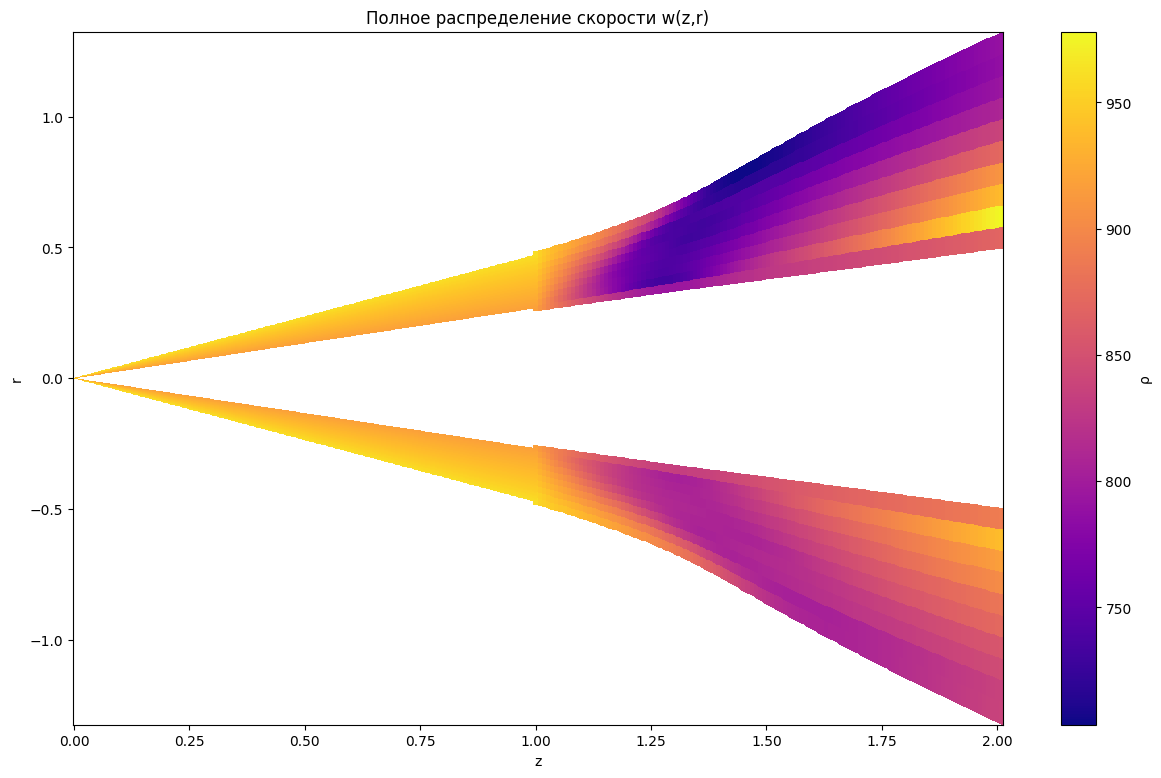

In [72]:
for func in ['rho', 'p', 'u', 'v', 'w']:
    distribution_plot(func)

In [114]:
rs.shape

(206, 180)

In [116]:
zs.shape

(206,)

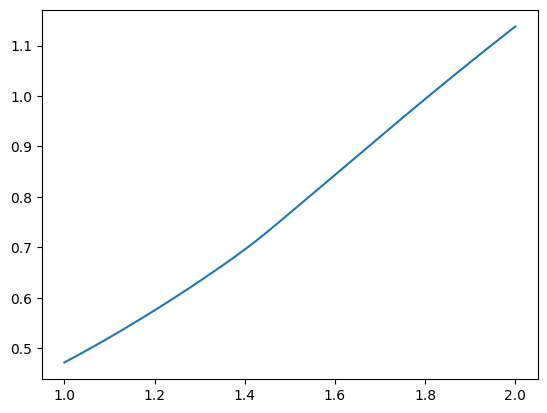

In [59]:
plt.plot(zs, rs[:,-1])

In [60]:
(rs[1,-1] - rs[0,-1]) / (zs[1] - zs[0])

0.4746753246753352

In [61]:
(rs[-1,-1] - rs[-2,-1]) / (zs[-1] - zs[-2])

0.7012987012988349